# Medium_range National Water Model Forecast
### Workflow for creating a 10-day (no ensemble members) or 8.5-day (with ensemble members) streamflow forecast given a date, time, and NHDplus COMID (stream segment identifier)

In [2]:
import gcsfs
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import pandas as pd
from scipy.interpolate import interp1d

%matplotlib inline

## Set up the Google Cloud File System

In [3]:
fs = gcsfs.GCSFileSystem(project='national-water-model')

# Set the parameters

In [1]:
date = '20190730' # a date
start_time = '00' # start at 00:00 because its easy at the moment
# comid = 4512772 # some small segment on the Potomac near DC
# comid = 229757 # the South Platte River in Denver
comid = 7471678 # somewhere on the Mississippi River

## Open all netcdf files of interest, concat them into an xarray multifile dataset -- **_1 for each member_**

- This step takes longer than expected due to reading from GCS over the internet

#### Prior to June 2019, there was only one medium range forecast, not 7 members. The if/else accounts for that but can most likely be removed in the future

In [4]:
datepath = f'national-water-model/nwm.{date}'
if 'medium_range_mem' in str(fs.ls(datepath)): 
    xr_datasets = []
    multi_mem = True
    len_forecast = '8.5-day'
    for i in range(1,8): # ensemble members
        mem = str(i)
        open_ncdfs = []
        for i in range(3, 205, 3): # for times 3-240 or 3-204 in steps of 3
            hr = str(i).zfill(3)
            filepath = f'national-water-model/nwm.{date}/medium_range_mem{mem}/nwm.t{start_time}z.medium_range.channel_rt_{mem}.f{hr}.conus.nc'
            file = fs.open(filepath, 'rb')
            open_ncdfs.append(file)
        mfdset = xr.open_mfdataset(open_ncdfs)
        xr_datasets.append(mfdset)

else:
    multi_mem = False
    len_forecast = '10-day'
    open_ncdfs = []
    for i in range(3, 241, 3): # for times 3-240 or 3-204 in steps of 3
        hr = str(i).zfill(3)
        filepath = f'national-water-model/nwm.{date}/medium_range_mem{mem}/nwm.t{start_time}z.medium_range.channel_rt.f{hr}.conus.nc'
        file = fs.open(filepath, 'rb')
        open_ncdfs.append(file)
    mfdset = xr.open_mfdataset(open_ncdfs)
    
print(f'Multi-member: {multi_mem}')

Multi-member: True


## Pull the data from each multifile xarray dataset, make a list of dictionaries

In [5]:
outjson = []
for ds in xr_datasets:
    output_da = ds.sel(feature_id=comid)['streamflow']
    times = output_da['time'].values.astype(str)
    arr = output_da.values
    d = {}
    d[ds.attrs['ensemble_member_number']] = dict(zip(times, arr))
    outjson.append(d)

## Dump them into a pandas dataframe

In [6]:
df = pd.concat([pd.read_json(json.dumps(x), orient='index') for x in outjson]).T
df['mean'] = df.mean(axis=1)
df.head()

,1,2,3,4,5,6,7,mean
2019-07-30 03:00:00,19904.549555,19904.549555,19904.549555,19904.549555,19904.549555,19904.549555,19904.549555,19904.549555
2019-07-30 06:00:00,19928.499555,19928.489555,19928.489555,19928.519555,19928.489555,19928.509555,19928.489555,19928.498126
2019-07-30 09:00:00,19961.409554,19961.389554,19961.399554,19961.419554,19961.419554,19961.409554,19961.399554,19961.406697
2019-07-30 12:00:00,20002.719553,20002.699553,20002.699553,20002.719553,20002.779553,20002.719553,20002.699553,20002.719553
2019-07-30 15:00:00,20051.059552,20051.029552,20051.029552,20051.049552,20051.149552,20051.049552,20051.039552,20051.058123


## Stats

In [7]:
stats = df.T.describe()
stats

,2019-07-30 03:00:00,2019-07-30 06:00:00,2019-07-30 09:00:00,2019-07-30 12:00:00,2019-07-30 15:00:00,2019-07-30 18:00:00,2019-07-30 21:00:00,2019-07-31 00:00:00,2019-07-31 03:00:00,2019-07-31 06:00:00,...,2019-08-06 09:00:00,2019-08-06 12:00:00,2019-08-06 15:00:00,2019-08-06 18:00:00,2019-08-06 21:00:00,2019-08-07 00:00:00,2019-08-07 03:00:00,2019-08-07 06:00:00,2019-08-07 09:00:00,2019-08-07 12:00:00
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,19904.549555,19928.498126,19961.406697,20002.719553,20051.058123,20104.509551,20160.870978,20217.805262,20272.945261,20324.119546,...,18789.125294,18809.558151,18812.939579,18800.173865,18773.151009,18734.295296,18686.241011,18631.631012,18572.868156,18512.095301
std,0.000000,0.011249,0.010302,0.026186,0.038703,0.029277,0.023561,0.017613,0.025555,0.045981,...,13.507763,13.199080,12.806755,12.368059,11.947251,11.557934,11.216372,10.937592,10.727544,10.582326
min,19904.549555,19928.489555,19961.389554,20002.699553,20051.029552,20104.489551,20160.849549,20217.789548,20272.919547,20324.079546,...,18774.269580,18795.169580,18799.099580,18786.919580,18760.439581,18722.059582,18674.409583,18620.109584,18561.579585,18500.959586
25%,19904.549555,19928.489555,19961.399554,20002.699553,20051.037052,20104.497051,20160.857049,20217.789548,20272.929547,20324.087046,...,18782.069580,18802.357080,18805.662080,18792.869580,18765.844581,18726.997081,18678.967082,18624.369584,18565.609585,18504.822086
50%,19904.549555,19928.493840,19961.408125,20002.719553,20051.049552,20104.499551,20160.864549,20217.802405,20272.934547,20324.104546,...,18785.544580,18806.099580,18809.614580,18796.979580,18770.059580,18731.299581,18683.309582,18628.744584,18569.999585,18509.214586
75%,19904.549555,19928.502055,19961.412054,20002.719553,20051.058480,20104.509551,20160.875621,20217.812048,20272.953833,20324.137046,...,18791.668866,18812.151008,18815.572079,18802.840294,18775.863152,18737.056367,18689.048154,18634.488155,18575.781013,18515.071372
max,19904.549555,19928.519555,19961.419554,20002.779553,20051.149552,20104.579551,20160.919549,20217.839548,20272.989547,20324.209546,...,18817.159579,18836.759579,18839.109579,18825.199579,18797.039580,18757.099581,18708.079582,18652.639583,18593.199584,18531.889586


## Plot the stream flow and the statistics

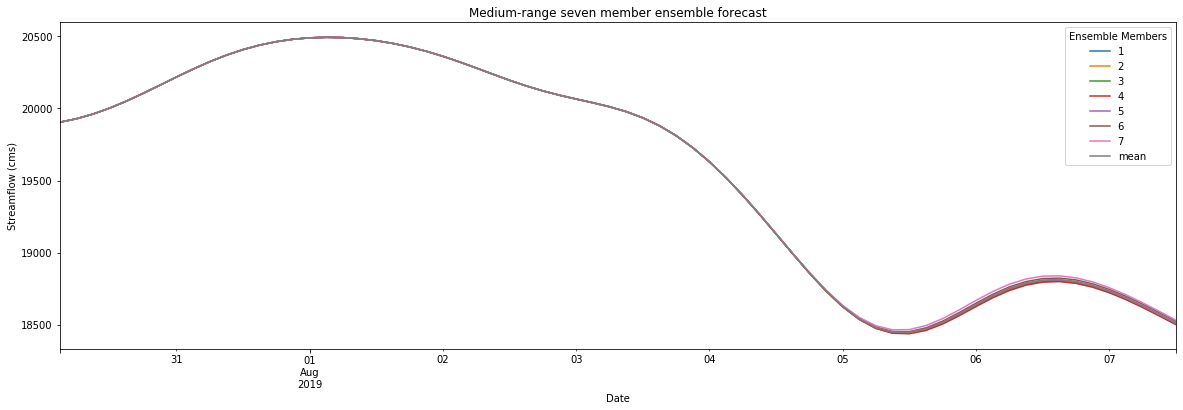

In [8]:
ax = df.plot(figsize=(20,6), title='Medium-range seven member ensemble forecast')
ax.legend(title='Ensemble Members')
ax.set(xlabel='Date', ylabel='Streamflow (cms)');

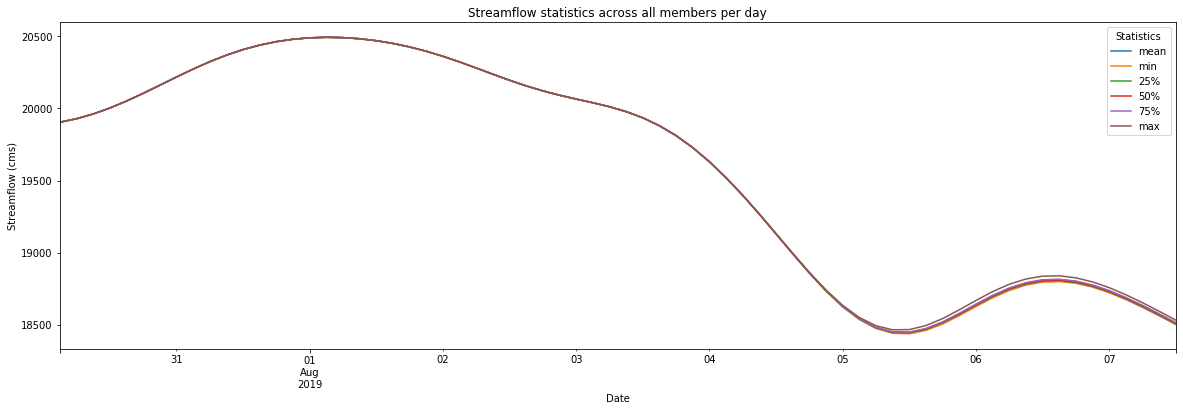

In [9]:
ax = stats.T.drop(columns=['count', 'std']).plot(figsize=(20,6), title ='Streamflow statistics across all members per day')
ax.legend(title='Statistics')
ax.set(xlabel='Date', ylabel='Streamflow (cms)');

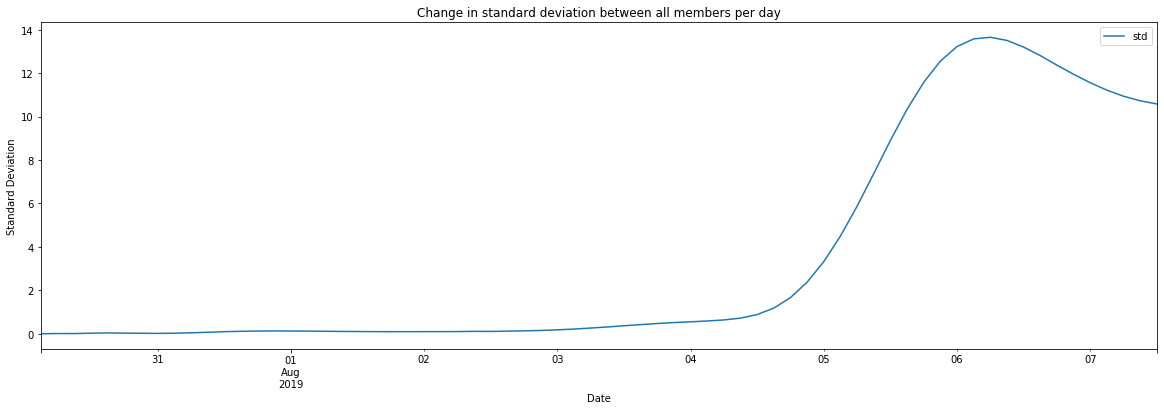

In [10]:
ax = stats.T.drop(columns=[x for x in list(stats.T.columns) if 'std' not in x]).plot(figsize=(20,6), title ='Change in standard deviation between all members per day')
ax.set(xlabel='Date', ylabel='Standard Deviation');

# Convert Flow to Stage

In [11]:
ds = xr.open_dataset(r'C:\Data\fcast_data\hydroprop-fulltable2D.nc')
dis_ds = ds.Discharge.sel(CatchId=comid)
dis_df = dis_ds.to_dataframe().reset_index().drop(columns=['CatchId'])

In [12]:
df.head()

,1,2,3,4,5,6,7,mean
2019-07-30 03:00:00,19904.549555,19904.549555,19904.549555,19904.549555,19904.549555,19904.549555,19904.549555,19904.549555
2019-07-30 06:00:00,19928.499555,19928.489555,19928.489555,19928.519555,19928.489555,19928.509555,19928.489555,19928.498126
2019-07-30 09:00:00,19961.409554,19961.389554,19961.399554,19961.419554,19961.419554,19961.409554,19961.399554,19961.406697
2019-07-30 12:00:00,20002.719553,20002.699553,20002.699553,20002.719553,20002.779553,20002.719553,20002.699553,20002.719553
2019-07-30 15:00:00,20051.059552,20051.029552,20051.029552,20051.049552,20051.149552,20051.049552,20051.039552,20051.058123


In [27]:
dis_df = dis_df.loc[1:]

In [28]:
dis_df.head()

,Stage,Discharge
1,0.3048,18.803703
2,0.6096,72.426845
3,0.9144,153.986456
4,1.2192,263.154022
5,1.5240,395.554424


## Make an interpolation function to convert from streamflow to stage based on the rating curve provided by the NWM

In [29]:
f = interp1d(dis_df.Discharge, dis_df.Stage, kind='cubic')
stage_df = df.apply(f)
stage_stats = stage_df.T.describe()

## Plot the forecasted stage depth

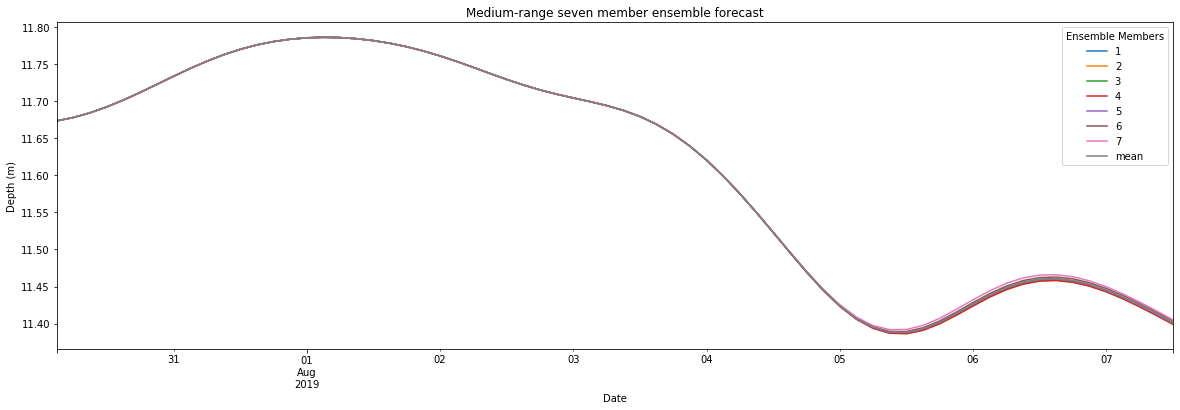

In [31]:
ax = stage_df.plot(figsize=(20,6), title='Medium-range seven member ensemble forecast')
ax.legend(title='Ensemble Members')
ax.set(xlabel='Date', ylabel='Depth (m)');

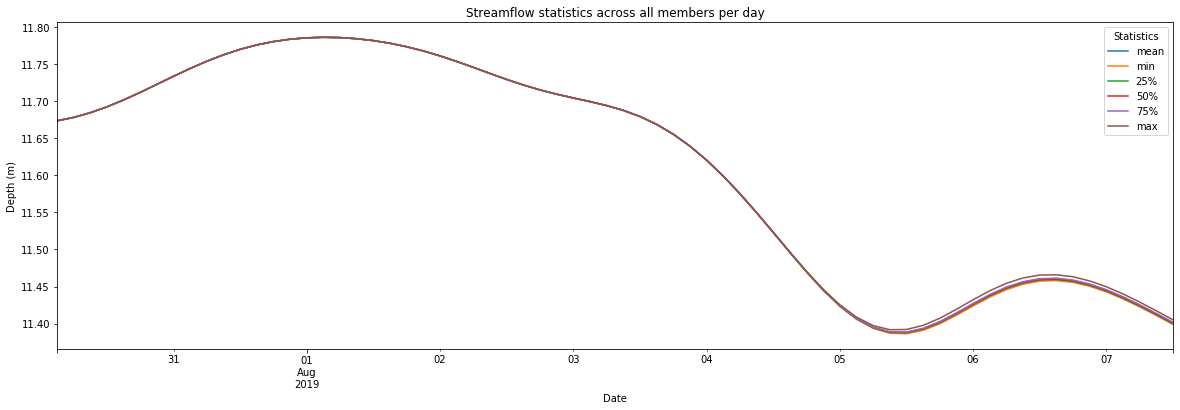

In [32]:
ax = stage_stats.T.drop(columns=['count', 'std']).plot(figsize=(20,6), title ='Streamflow statistics across all members per day')
ax.legend(title='Statistics')
ax.set(xlabel='Date', ylabel='Depth (m)');

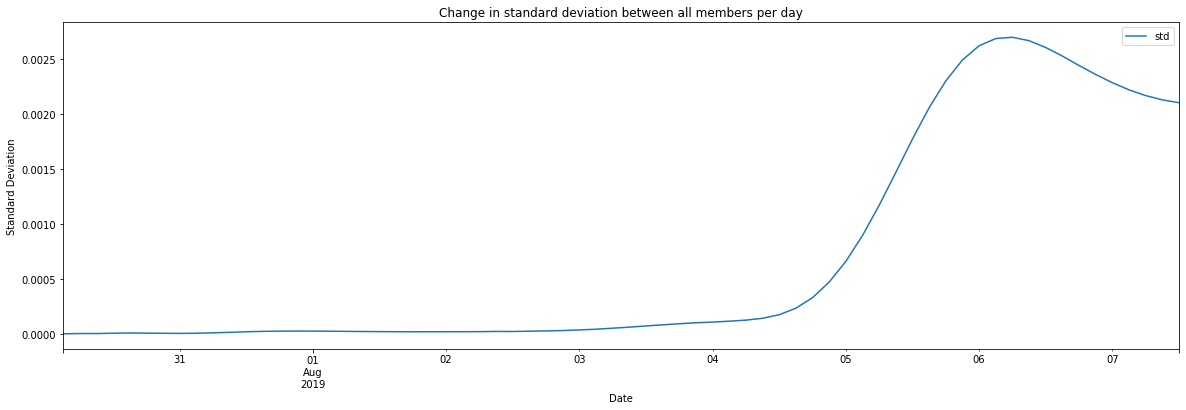

In [33]:
ax = stage_stats.T.drop(columns=[x for x in list(stats.T.columns) if 'std' not in x]).plot(figsize=(20,6), title ='Change in standard deviation between all members per day')
ax.set(xlabel='Date', ylabel='Standard Deviation');